STUDENT: JOAN ROSSELLO BOVER

In [22]:
import numpy as np
import scipy as sp
from scipy import io
import cv2 as cv 
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (12.0, 10.0)

# Part B: Condensation

Now, we will track a given shape (template) as it moves in a sequence of
frames. Our shape/appearance model is trivial: just a template, given.
We will only explore simple motion models. 
Such models may contain a variable that switches between cars and pedestrians, or traffic in different directions, or accelerating etc.
 
**Note:** depending on the motion model, the state w will have different numbers of dimensions (not just 2, though that's the default). 

Most of this algorithm should be copied from Part A.
An important difference is that now we'll actually compute the likelihood using the (provided) computeLikelihood() function.


TO DOs:

- Complete the To Dos from part A.
- Change the state to have 2 more degrees of freedom: velX and velY.
  (This will require you to change how state-predictions are made, and 
  how they are converted to measurement-space)
- Try varying the number of particles: 2000, 500, 100,... What can you observe?
- - The solution with a low number of particles is extremely dependent on the initial conditions (i.e. the initial random particles that are generated). If none of the initial particles happen to be near the car wheel we are trying to identify, the particle filter will never converge towards the wheel because there are simply no particles near the wheel to which we can give large weights, so the solution will converge to the position of whatever particle happens to give the highest likelihood, even if that likelihood is quite low (because the high likelihood that we would obtain if a particle were near the wheel in question never comes into play and so it cannot eclipse the wrong predictions). 
- - The more particles we have, the highest the probability that some of the starting particles will be close to the object we want to identify and the more probability we have that the particle filter will evolve towards that object and that we'll get an accurate result.
- Try varying the noise level. What can you observe?
- - If noise is too small (i.e. std = 1), then the new particles will be very close to the old particles and the algortihm will converge very slowly. Moreover, if we are unlucky and on an iteration when we select the particles to propagate we don't select any of the particles near the object we want to track (even if they have large weight), then the model will have deviated from the right solution and it will converge to something else.
- - If noise is too large, it's like we're initialising the particles randomly in every iteration and the fact that we'll find the appropriate prediction will depend on whether any of those particles will land on the object we want to track or not, because the presence of large noise makes the new particles be placed far away from the old particles that had high likelihood.
- - We need to find a level of noise that is in between, which allows the particle filter to converge, but it doesn't limit itself to scales that are too small.
  


In [23]:
#Likelihood function is simple patch similarity
#Note that below, we add a few 'corrections', such as
#manually masking out the sky for better results

def computeLikelihood(image, template):
    #opencv's available methods - experiment with these
    #careful what range the output is!
    methods = [cv.TM_CCOEFF, cv.TM_CCOEFF_NORMED, cv.TM_CCORR,
            cv.TM_CCORR_NORMED, cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]
    
    likelihood = cv.matchTemplate(image, template, methods[0])
    #we manually eliminate incorrect matches in the sky
    #since we know that there cannot be any cars in those areas
    likelihood[:int(likelihood.shape[0] / 2), :] = 0.0
    
    #we can then pad to make this the size of the input image (for easier indexing)
    pad_first = int(template.shape[0])
    pad_second = int(template.shape[1])
    pad_amounts = ((pad_first, pad_first), (pad_second, pad_second))
    likelihood = np.pad(likelihood, pad_amounts, 'constant')
    
    return likelihood

We are matching this template with shape:  (27, 18, 3)


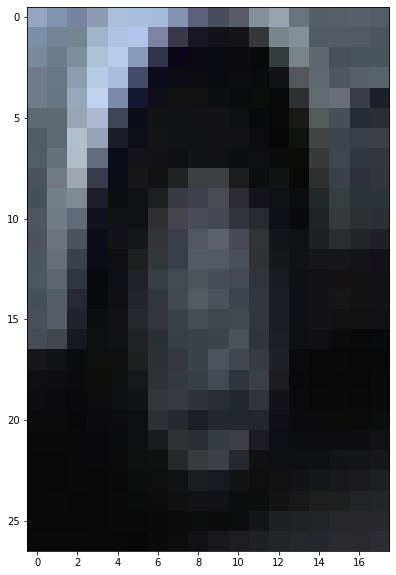

Processing Frame 0


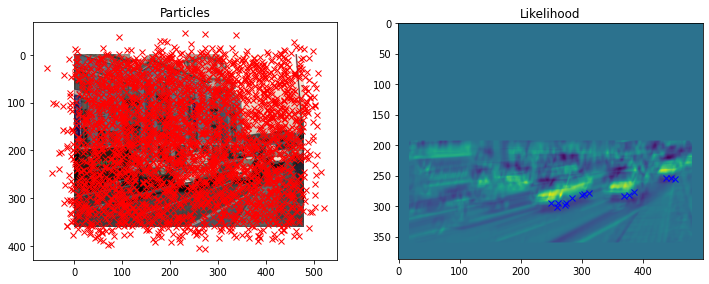

Processing Frame 1


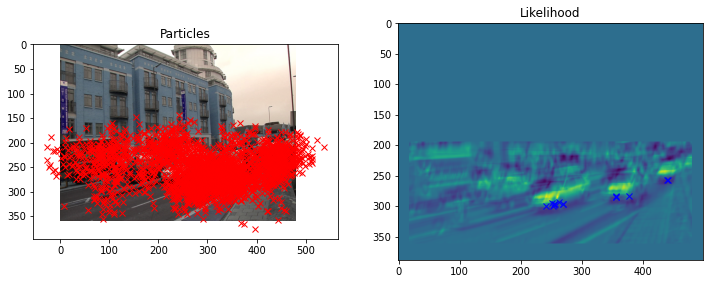

Processing Frame 5


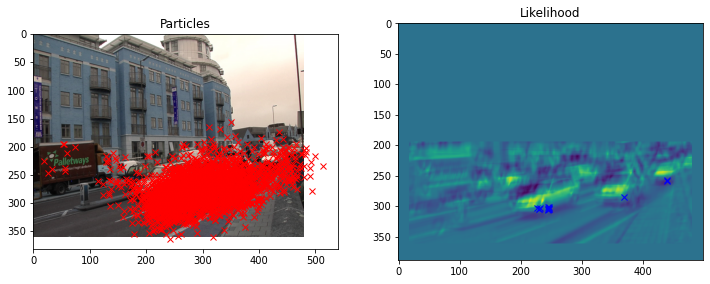

Processing Frame 10


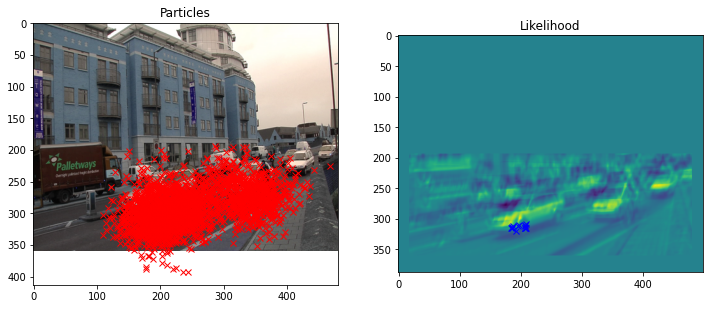

Processing Frame 15


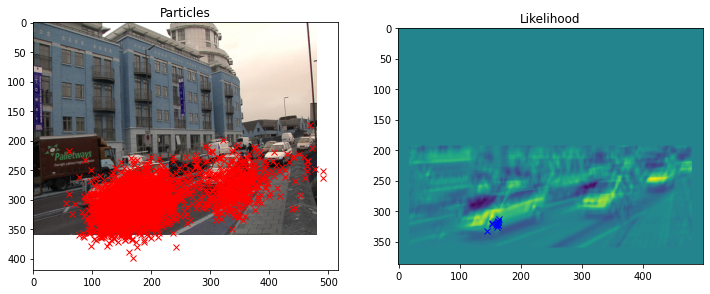

Processing Frame 22


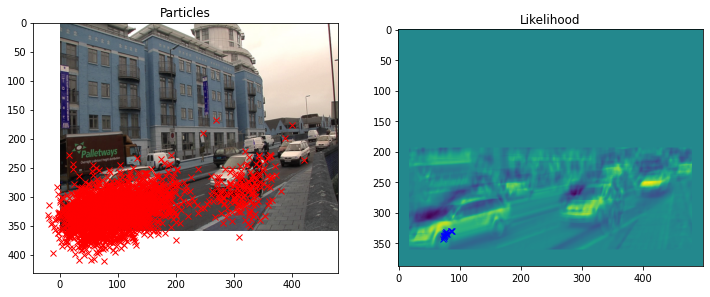

In [24]:
# Load template and starting position ('pos'), which come from frame 871.
template = sp.io.loadmat('data/Template.mat')['pixelsTemplate']

#let's show the template - part we are looking for in the images (note: images are larger dimension than template)
print('We are matching this template with shape: ', template.shape)
plt.imshow(template)
plt.show()

# Load images
images = []
iFrame = 0
for frameNum in range(872, 894 + 1): # 23 images
    imageName = 'data/HillsRdSkipFrames_%07d.png' % frameNum
    images.append(cv.imread(imageName))
    plt.show()
    iFrame += 1

imgHeight, imgWidth, colors = images[0].shape
numParticles = 3000 # try varying this and see what happens --> 3000 particles gave more consistent results
weight_of_samples = np.ones((numParticles,1))

# TO DO: normalize the weights (may be trivial this time) [done]
weight_of_samples = weight_of_samples / np.sum(weight_of_samples) #replace this 

# Initialize which samples from "last time" we want to propagate: all of
# them!:
samples_to_propagate = range(0, numParticles)


# ============================
# The first two dimensions represent position while the last two now represent velocity:
numDims_w = 4; 
# Here we randomly initialize some particles throughout the space of w:
particles_old = np.random.rand(numParticles, numDims_w) # each particle corresponds to a row, position and velocities are in the columns
particles_old[:,0] = particles_old[:,0] * imgHeight # y-axis position
particles_old[:,1] = particles_old[:,1] * imgWidth # x-axis position
particles_old[:,2] = 10.0 * np.random.randn(numParticles) # velocity in y-axis (velY)
particles_old[:,3] = 10.0 * np.random.randn(numParticles) # velocity in x-axis (velX)
# ============================

for iTime in range(23):
    if iTime == 0 or iTime == 1 or iTime == 5 or iTime == 10 or iTime == 15 or iTime == 22: # only plot a few frames
        print('Processing Frame', iTime) 
    # TO DO: compute the cumulative sume of the weights. [done]
    cum_hist_of_weights = np.cumsum(weight_of_samples, axis=0) # replace this 


    # ==============================================================
    # Resample the old distribution at time t-1, and select samples, favoring
    # those that had a higher posterior probability.
    # ==============================================================
    samples_to_propagate = np.zeros(numParticles, dtype=np.int32)
    
    # Pick random thresholds in the cumulative probability's range [0,1]:
    some_threshes = np.random.rand(numParticles)


    # For each random threshold, find which sample in the ordered set is
    # the first one to push the cumulative probability above that
    # threshold, e.g. if the cumulative histogram goes from 0.23 to 0.26
    # between the 17th and 18th samples in the old distribution, and the
    # threshold is 0.234, then we'll want to propagate the 18th sample's w
    # (i.e. particle #18).
    
    for sampNum in range(numParticles):
        thresh = some_threshes[sampNum]
        for index in range (numParticles):
            if cum_hist_of_weights[index] > thresh:
                break
        samples_to_propagate[sampNum] = index
    
    # Note: it's ok if some of the old particles get picked repeatedly, while
    # others don't get picked at all.

    # Predict where the particles from the old distribution of 
    # state-space will go in the next time-step. This means we have to apply 
    # the motion model to each old sample.

    particles_new = np.zeros(particles_old.shape)
    particles_old = particles_old[samples_to_propagate,:]
    for particleNum in range(numParticles):      
        # TO DO: Incorporate some noise, e.g. Gaussian noise with std 10,
        # into the current location (particles_old), to give a Brownian
        # motion model with changing velocity. Remember: the first two 
        # dimensions of w represent position while the last two represent velocity 
        # and you should add noise to both. 

        # note that during the duration of the frame, we move from x_t-1 to x_t and y_t-1 to y_t with constant
        # velocities velX and velY
        
        noisePosition = np.random.normal(0, 20, 2) # replace this -- I used std = 20 because it gave more consisten results
        noiseVelocity = np.random.normal(0, 2, 2) # replace this -- we add a gaussian noise with std = 2 to the velocity, 
                                                  # which seems reasonable, given the velocity mean is around 10
        
        particles_new[particleNum, 2:] = particles_old[particleNum, 2:] + noiseVelocity #replace this - velocities
        
        particles_new[particleNum, :2] = particles_old[particleNum, :2] + particles_old[particleNum, 2:] + noisePosition #replace this - position
        # particles_new[particleNum, :2] = particles_old[particleNum, :2] + noisePosition # with only 2 dofs
        particles_new[particleNum, :2] = np.round(particles_new[particleNum, :2]) # Round the particles_new to simplify Likelihood evaluation.
    
    # You can experiment with the motion model above to have
    # different degrees of freedom, and optionally completely different
    # motion models.
    
    #calculate likelihood function
    likelihood = computeLikelihood(images[iTime], template)
    
    #plot particles
    if iTime == 0 or iTime == 1 or iTime == 5 or iTime == 10 or iTime == 15 or iTime == 22: # only plot a few frames
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(images[iTime])
        axarr[0].set_title('Particles')
        # now draw the particles onto the image
        axarr[0].plot(particles_new[:,1], particles_new[:,0], 'rx')
        
        #plot the likelihood
        axarr[1].imshow(likelihood)
        axarr[1].set_title('Likelihood')

    
    # From here we incorporate the data for the new state (time t):
    # The new particles accompanying predicted locations in state-space
    # for time t, are missing their weights: how well does each particle
    # explain the observations x_t?
    for particleNum in range(numParticles):

        # Convert the particle from state-space w to measurement-space x:
        # Note: that step is trivial here since both are in 2D space of image
        # coordinates

        # Within the loop, we evaluate the likelihood of each particle:
        particle = particles_new[particleNum, :]
        # Check that the predicted location is a place we can really evaluate
        # the likelihood.
        inFrame = particle[0] >= 0.0 and  particle[0] <= imgHeight and particle[1] >= 0.0 and particle[1] <= imgWidth
        if inFrame:
            minX = particle[1]
            minY = particle[0]

            weight_of_samples[particleNum] = likelihood[int(minY), int(minX)]
        else:
            weight_of_samples[particleNum] = 0.0

    # TO DO: normalize the weights [done]
    weight_of_samples = weight_of_samples / np.sum(weight_of_samples) #replace this

    #Plot the 15 best scoring particles
    indices = np.argsort(weight_of_samples, axis = 0)
    bestScoringParticles = particles_new[np.squeeze(indices[-15:]), :]
    
    if iTime == 0 or iTime == 1 or iTime == 5 or iTime == 10 or iTime == 15 or iTime == 22: # only plot a few frames
        plt.plot(bestScoringParticles[:,1]+template.shape[1]/2, bestScoringParticles[:,0]+template.shape[0]/2, 'bx')
        plt.show()
    
    # Now we're done updating the state for time t. 
    # For Condensation, just clean up and prepare for the next round of 
    # predictions and measurements:
    particles_old = particles_new


Note: some of the TO DOs are already answered at the beginning of the notebook. Now we just comment on the resulting plots.

Note that we just plot some of the frames. They have been chosen at approprate intervals in order to get the general idea of the performance of the algorithm. 

As in labA, we see the particle filter coming into play, but this time it is with a video, where the object we are tracking is moving, so its position changes with every frame. The principle of the particle filter is the same as explained int labA, so I will not repeat myself too much in terms of generating equally weighted random particles across the whole image in the first iteration and then re-weighting the particles depending on their likelihood to represent the object we are tracking, generating new particles, converging to our template, etc.

In this case, however, we can observe how the use of more than 2 degrees of freedom can be beneficial.

If we only use 2 degrees of freedom (position of the particles), the particle filter still does a very good job at tracking the template, even if the object is moving frame by frame, since the movement is not too fast, hence the new position is not too far off from the  position in the old frame, and so the particles with high likelihood will still be near the new area with high likelihood (and also remember we add noise, which can play to our advantage this time). However, it was noticeable that towards the latter frames, even though the best scoring particles are around the wheel we are tracking, they are not as spot on as in the early frames.

This is solved by adding velocities and using 4 degrees of freedom. In this case, the particles in the latter frames are as spot on tracking the target as in the early frames (once they have converged - i.e. after around frame 5), thanks to the fact that the velocities take into account the movement taking place from frame to frame.

